# Transfer learning to classify wells

propagate the images through VGG16 until fc8 layer,

then extract its features and apply a few traditional classifiers on them, linear SVM and Random Forest.

In [57]:
# VGG16 implementation in TensorFlow taken from 
# Davi Frossard, 2016                       
# http://www.cs.toronto.edu/~frossard/post/vgg16/                                      
#
# VGG16 (aka OxfordNet) CNN taken from:
# https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md 
# Paper: https://arxiv.org/abs/1409.1556

In [9]:
!whoami
!date
!pwd
!nvidia-smi

root
Thu May 11 13:59:26 UTC 2017
/notebooks/CODE/project_warms
Thu May 11 13:59:27 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.39                 Driver Version: 375.39                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 0000:05:00.0     Off |                  N/A |
| 23%   37C    P8    16W / 250W |      0MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:            

In [10]:
# !pip install tqdm
# !pip install scikit-image
# !pip install seaborn

In [11]:
dir_foreground = '/notebooks/CODE/project_warms/BBBC010_v1_foreground/'
dir_data = '/notebooks/CODE/project_warms/HDF5/'

In [12]:
weights_save_dir = '/notebooks/CODE/project_warms/CNN_weights/'
tensorboard_save_dir = '/notebooks/CODE/project_warms/tensorboard_logs/'
VGG_dir = '/notebooks/CODE/project_warms/VGG/'
weightsFile = '/notebooks/CODE/project_warms/VGG/vgg16_weights.npz'

In [126]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import seaborn as sns

import os
import pandas
from pandas import Series
import copy
import pickle

from __future__ import division, print_function, absolute_import # to avoid integer division

import re
import itertools

# progress bar to monitor loops
from tqdm import *
from time import gmtime, strftime

# pylab.rcParams['figure.figsize'] = (20.0, 20.0)
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# suppress e+10... notation
pandas.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

import skimage
from time import strftime, localtime

from skimage import data, io, draw, transform #http://scikit-image.org/docs/stable/

%matplotlib inline

import collections

import h5py

import sys
sys.path.insert( 0, VGG_dir )

import gzip
import random

from sklearn.svm import SVC, LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

# for cross-validation
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold, cross_val_predict

# for confusion matrix
from sklearn import metrics
def measure_performance(y, y_pred, show_accuracy = True,
show_classification_report = True, show_confussion_matrix = True):
    if show_accuracy:
        print( "Accuracy:{0:.6f}".format(metrics.accuracy_score(y, y_pred)), "\n")
        
    if show_classification_report:
        print( "Classification report")
        print( metrics.classification_report(y, y_pred), "\n")
        
    if show_confussion_matrix:
        print( "Confusion matrix")
        print( metrics.confusion_matrix(y, y_pred), "\n")

In [14]:
def one_hot(Y):
    """
        Converts a vector of classes into a one-hot encoded matrix 
        
        Y -- a numpy vector of class labels
        
    """
    import numpy as np
    
    d = np.zeros((len(Y), len(np.unique(Y))), dtype='uint8')
    for row, col in enumerate(Y):
        d[row, col] = 1 
    return d

### load foreground images and labels

In [15]:
dir_data

'/notebooks/CODE/project_warms/HDF5/'

In [16]:
hdf5_X = h5py.File( dir_data + 'X_foreground.hdf5', 'r')
X_data = hdf5_X[list(hdf5_X.keys())[0]]

In [17]:
X_data

<HDF5 dataset "X_foreground": shape (100, 520, 696, 1), type "<f4">

## Make proper VGG input
since VGG accepts images with 3 channels,

    -for foreground images with one channel: replicate one channel 3 times and pass it through VGG
    
    -for raw images with two channels: repicate each channel 3 times, pass each through VGG and cbind the resulting data frames (done, but not shown here)

In [19]:
X_data_ch0 = np.zeros( (X_data.shape[0], X_data.shape[1], X_data.shape[2], 3) )

X_data_ch0[:,:,:,0] = X_data[:,:,:,0]
X_data_ch0[:,:,:,1] = X_data[:,:,:,0]
X_data_ch0[:,:,:,2] = X_data[:,:,:,0]

# Pass images through VGG to obtain meaningful features

In [20]:
import tensorflow as tf
import vgg16

In [21]:
tf.__version__

'1.0.0'

In [22]:
X_data_ch0.shape

(100, 520, 696, 3)

In [23]:
#### define the input shape of our images and also the vgg16 net.
#### the shape will be resized to 224x224 pixels because that is the original size of the vgg16 net for imagenet
def VGG_pass(X_pred):
    tf.reset_default_graph()

    imgs = tf.placeholder(tf.float32, [1, X_pred.shape[1], X_pred.shape[2], X_pred.shape[3]])
    vgg = vgg16.vgg16(imgs, numClasses = 1000, isPreprocessed = False, fc_size=4096)

    data_vgg = np.zeros( (len(X_pred), 4096), dtype = np.float32 )

    print( "starting feature extraction")
    print( strftime("%Y-%m-%d %H:%M:%S", gmtime()))

    sess = tf.Session( )

    sess.run( tf.global_variables_initializer() )
    vgg.loadWeights(weightsFile, sess)

    for row, i in enumerate( tqdm( range(len(X_pred)) ) ):

        img = X_pred[i, :, :, :]
        data_vgg[row] = sess.run( vgg.fc1l, feed_dict = {vgg.imgs: [img]} )
        
    sess.close()
    return data_vgg

In [24]:
data_features = VGG_pass(X_data_ch0)

Assuming that no=preposseing is done the pixels should have a range approx [0.0, 255]
starting feature extraction
2017-05-11 14:14:52
0 name in weight file conv1_1_W (3, 3, 3, 64)  name in graph  conv1_1/weights:0
1 name in weight file conv1_1_b (64,)  name in graph  conv1_1/biases:0
2 name in weight file conv1_2_W (3, 3, 64, 64)  name in graph  conv1_2/weights:0
3 name in weight file conv1_2_b (64,)  name in graph  conv1_2/biases:0
4 name in weight file conv2_1_W (3, 3, 64, 128)  name in graph  conv2_1/weights:0
5 name in weight file conv2_1_b (128,)  name in graph  conv2_1/biases:0
6 name in weight file conv2_2_W (3, 3, 128, 128)  name in graph  conv2_2/weights:0
7 name in weight file conv2_2_b (128,)  name in graph  conv2_2/biases:0
8 name in weight file conv3_1_W (3, 3, 128, 256)  name in graph  conv3_1/weights:0
9 name in weight file conv3_1_b (256,)  name in graph  conv3_1/biases:0
10 name in weight file conv3_2_W (3, 3, 256, 256)  name in graph  conv3_2/weights:0
11 name in weig

  0%|          | 0/100 [00:00<?, ?it/s]

31 name in weight file fc8_b (1000,)  name in graph  fc3/biases:0


100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


In [26]:
hdf5_X = h5py.File( dir_data + 'X_foreground_vgg.hdf5', 'w')
hdf5_X.create_dataset( 'X_raw_vgg', data = data_features, dtype = 'float32', chunks = True  )
hdf5_X.close()

In [27]:
dir_data

'/notebooks/CODE/project_warms/HDF5/'

## split into training and validation randomly

In [298]:
data_features.shape

(100, 4096)

In [28]:
np.random.seed(879)
index_train = np.random.choice( len(data_features), int( len(data_features) * 0.8), replace=False)
index_val = np.setdiff1d( range( len(data_features) ), index_train)

index_train

array([21, 28, 99, 34, 48, 95, 61,  3, 62, 14, 57, 44, 91, 80,  8, 86, 41,
       35, 11, 59, 98, 55, 69, 75, 72, 97, 65, 25, 77, 23, 88, 37, 89, 40,
       76, 94, 60, 46, 26, 92, 70, 29, 42, 38, 90, 45, 17, 10, 49, 47, 74,
        6, 52, 67, 43, 30,  9, 39, 79,  2,  4, 71, 56, 36, 63, 22, 84, 83,
       93, 81, 33, 53, 73, 18, 13, 96, 78, 64, 68, 87])

In [29]:
X_train = data_features[index_train,...]
X_val = data_features[index_val,...]

In [30]:
X_train.shape, X_val.shape

((80, 4096), (20, 4096))

In [31]:
labels_foreground = pandas.read_csv(dir_data + 'labels_foreground.csv',
                     sep = ',',
                     encoding = 'utf-8')

In [32]:
labels_foreground = labels_foreground['label'].values

In [33]:
Y_train = labels_foreground[index_train]
Y_val = labels_foreground[index_val]

In [34]:
Y_train.shape, Y_val.shape

((80,), (20,))

# train linear SVM on VGG features

### since SVM depends on the distance/scale, normalize the features(dataset) before inputting it into SVM!

In [35]:
X_train_mean = np.mean( X_train, axis = 0)
X_train_std = np.std( X_train, axis = 0)

X_train = (X_train - X_train_mean ) / (X_train_std + 0.0001)

# normalize the validation also with X_train_mean to avoid info leakage frpom validation set
X_val = (X_val - X_train_mean ) / (X_train_std + 0.0001)

In [37]:
X_train.shape

(80, 4096)

In [38]:
X_train.min(), X_train.max()

(-4.6533394, 4.8492541)

In [39]:
X_val.min(), X_val.max()

(-5.8187294, 5.1594267)

## Initialize SVM
 - use linear kernel, sa with n << p, the data is always separable in the feature space
 - use grid search for the penalty parameter C
 - use 10-fold stratified cross validation to avoid overfitting and class imbalance in the folds
 - use class weights inversely proportiponal to the number of obs. per class to alleviate possible class imbalance

In [85]:
n,v = np.unique( Y_train, return_counts = True)
n, v

(array([0, 1]), array([41, 39]))

In [150]:
Y_train

array([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0])

In [166]:
## Grid search on the training set

# The "balanced" mode uses the values of y to automatically adjust
# weights inversely proportional to class frequencies in the input data
# as ``n_samples / (n_classes * np.bincount(y))`

param_grid = {'C': np.logspace(-10, 0, num = 11) }
cv_train = StratifiedKFold( Y_train, n_folds = 10 )

# liblinear LinearSVC() scales better for many features and obs. than libsvm SVC() function
svm_model = LinearSVC( class_weight = 'balanced')
svm1 = GridSearchCV( svm_model, 
                     param_grid,
                     cv = cv_train,
                     n_jobs = -1 # important to run it on all CPU cores for speed
)

In [167]:
svm1_fit = svm1.fit( X_train, Y_train )

In [168]:
svm1_best = svm1_fit.best_estimator_
svm1_best

LinearSVC(C=1e-10, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [133]:
svm1_pred = svm1_best.predict( X_val )

In [164]:
measure_performance( Y_val, svm1_pred)

Accuracy:1.000000 

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       1.00      1.00      1.00        13

avg / total       1.00      1.00      1.00        20
 

Confusion matrix
[[ 7  0]
 [ 0 13]] 



### Cross-validation scores

In [175]:
cv_scores_train = cross_val_score(svm1_best, X_train, Y_train, cv = cv_train )
print("Accuracy: %0.3f (+/- %0.3f)" % (cv_scores_train.mean(), cv_scores_train.std() * 2))

Accuracy: 0.989 (+/- 0.067)


In [186]:
# Leave one out CV on the validation set
cv_scores_val = cross_val_score(svm1_best, X_val, Y_val, cv = KFold( len(Y_val), n_folds = len(Y_val) ) )
print("Accuracy: %0.3f (+/- %0.3f)" % (cv_scores_val.mean(), cv_scores_val.std() * 2))

Accuracy: 1.000 (+/- 0.000)


In [328]:
# save the model to disk
pickle.dump(svm1_best, open(  dir_data + '../' + 'svm_vgg_foreground' , 'wb'))

# Results

### We also passed the origirnal raw images without normalization through VGG and ran the same SVM training cycle.
### Below are the results for comparison.

In [104]:
# Foreground binary images

# LinearSVC(C=1e-10, class_weight='balanced', dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#      verbose=0)

# Accuracy:1.000000 

# Classification report
#              precision    recall  f1-score   support

#           0       1.00      1.00      1.00         7
#           1       1.00      1.00      1.00        13

# avg / total       1.00      1.00      1.00        20
 

# Confusion matrix
# [[ 7  0]
#  [ 0 13]] 

# ==================================================================

# raw data, without normalization, VGG-SVM

# SVC(C=0.0001, cache_size=200, class_weight='balanced', coef0=0.0,
#   decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
#   max_iter=-1, probability=True, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)


# Accuracy:0.650000 

# Classification report
#              precision    recall  f1-score   support

#           0       0.46      1.00      0.63         6
#           1       1.00      0.50      0.67        14

# avg / total       0.84      0.65      0.66        20
 

# Confusion matrix
# [[6 0]
#  [7 7]] 

(20,)

# train Random Forest on VGG features

In [178]:
rf_model = RandomForestClassifier(max_depth = None,
                                 class_weight = 'balanced',
                                 min_samples_split = 2,
                                 n_estimators = 1000,
                                 max_features = int(np.sqrt(X_train.shape[1])), 
                                 random_state = 0,
                                 n_jobs = -1, # to parallelize jobs across all processors
                                 oob_score = True)

In [193]:
X_train.shape

(80, 4096)

In [179]:
rf1 = rf_model.fit(X_train, Y_train )

In [181]:
rf1_pred = rf1.predict( X_val )

In [182]:
measure_performance( Y_val, rf1_pred )

Accuracy:1.000000 

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       1.00      1.00      1.00        13

avg / total       1.00      1.00      1.00        20
 

Confusion matrix
[[ 7  0]
 [ 0 13]] 



### Cross-validation scores

In [183]:
cv_scores_train = cross_val_score(rf1, X_train, Y_train, cv = cv_train )
print("Accuracy: %0.3f (+/- %0.3f)" % (cv_scores_train.mean(), cv_scores_train.std() * 2))

Accuracy: 1.000 (+/- 0.000)


In [187]:
# Leave one out CV on the validation set
cv_scores_val = cross_val_score(rf1, X_val, Y_val, cv = KFold( len(Y_val), n_folds = len(Y_val) ) )
print("Accuracy: %0.3f (+/- %0.3f)" % (cv_scores_val.mean(), cv_scores_val.std() * 2))

Accuracy: 1.000 (+/- 0.000)


# Visualize VGG features

### Importance of fc8 features from Random forest

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


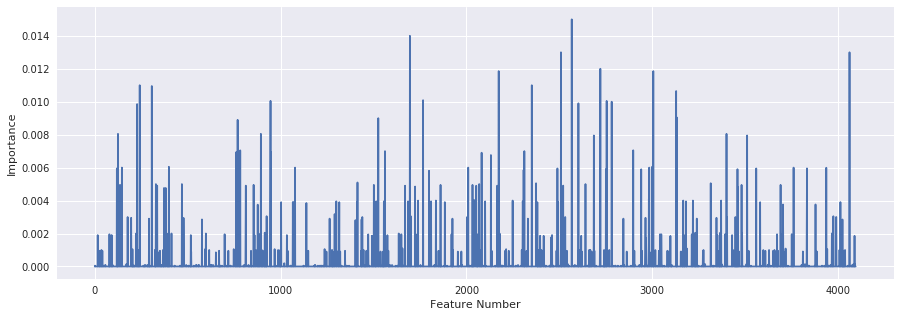

In [203]:
plt.figure( figsize = (15,5))
plt.plot( rf_model.feature_importances_)
plt.xlabel('Feature Number')
plt.ylabel('Importance')

### Pixel importance on the fc8 layer

/usr/local/lib/python3.4/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


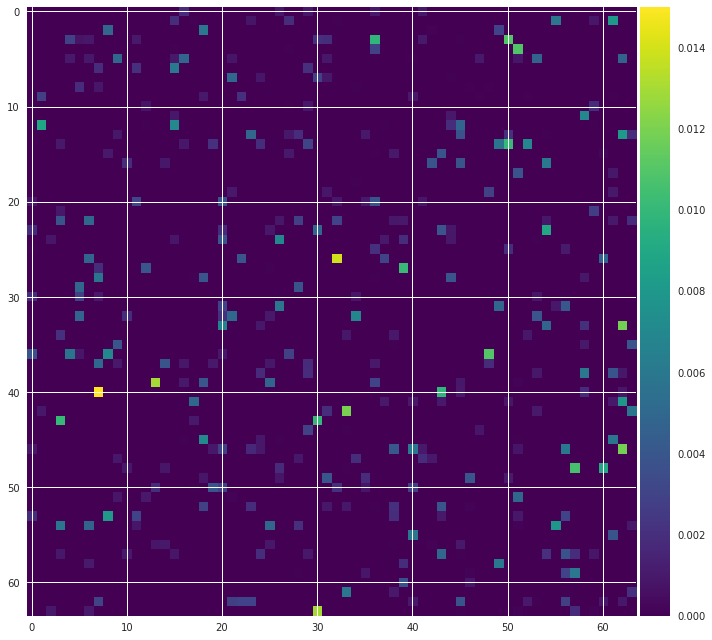

In [224]:
plt.figure( figsize = (10,10))
io.imshow( np.reshape(rf_model.feature_importances_, (64,64)) );

## Visualize intermediate VGG16 layers

In [236]:
import keras

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Activation, pooling
from keras.layers import Dropout, BatchNormalization, Convolution2D, MaxPooling2D
from keras import initializers
from keras.optimizers import Adam, RMSprop

from keras.layers import Lambda, Input
from keras.models import Model
from keras.backend import tf as ktf

from keras.preprocessing.image import ImageDataGenerator

# pretrained model with weigths
from keras.applications.vgg16 import VGG16, preprocess_input

# to reshape the input images into correct shape suitable for VGG
from scipy.misc import imread, imresize

Using TensorFlow backend.


In [237]:
keras.__version__

'2.0.2'

In [313]:
model1 = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

In [315]:
model1.layers

In [320]:
X_data_ch0.shape

(100, 520, 696, 3)

In [327]:
### reshape input images, as VGG requires 224 by 224 pixels with 3 channels

In [297]:
X_resized = np.zeros( (100, 224, 224, 3))

for image in range(X_data_ch0.shape[0]):
    for channel in range(X_data_ch0.shape[3]):
        X_resized[image,:,:,channel] = imresize(X_data_ch0[image,:,:,channel], (224, 224))   

### an original binary image

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


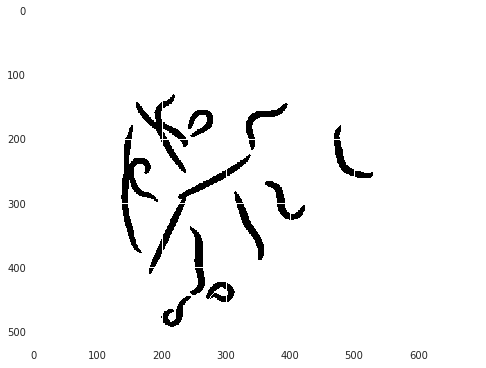

In [358]:
plt.figure( figsize = (8,8))
plt.imshow( X_data[0, :, :, 0 ] )

### Now display this image at the layer with index1

In [363]:
def layer_features(index1, data1):
    intermediate_layer_model = Model(inputs = model1.input,
                                     outputs = model1.get_layer(index =  index1 ).output)
    index_features = intermediate_layer_model.predict( data1)
    return index_features
    

In [367]:
image1 = np.expand_dims( X_resized[0,:,:,:], axis = 0)

In [378]:
intermediate_output = layer_features(2, image1)

In [379]:
intermediate_output.shape

(1, 224, 224, 64)

/usr/local/lib/python3.4/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.4/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


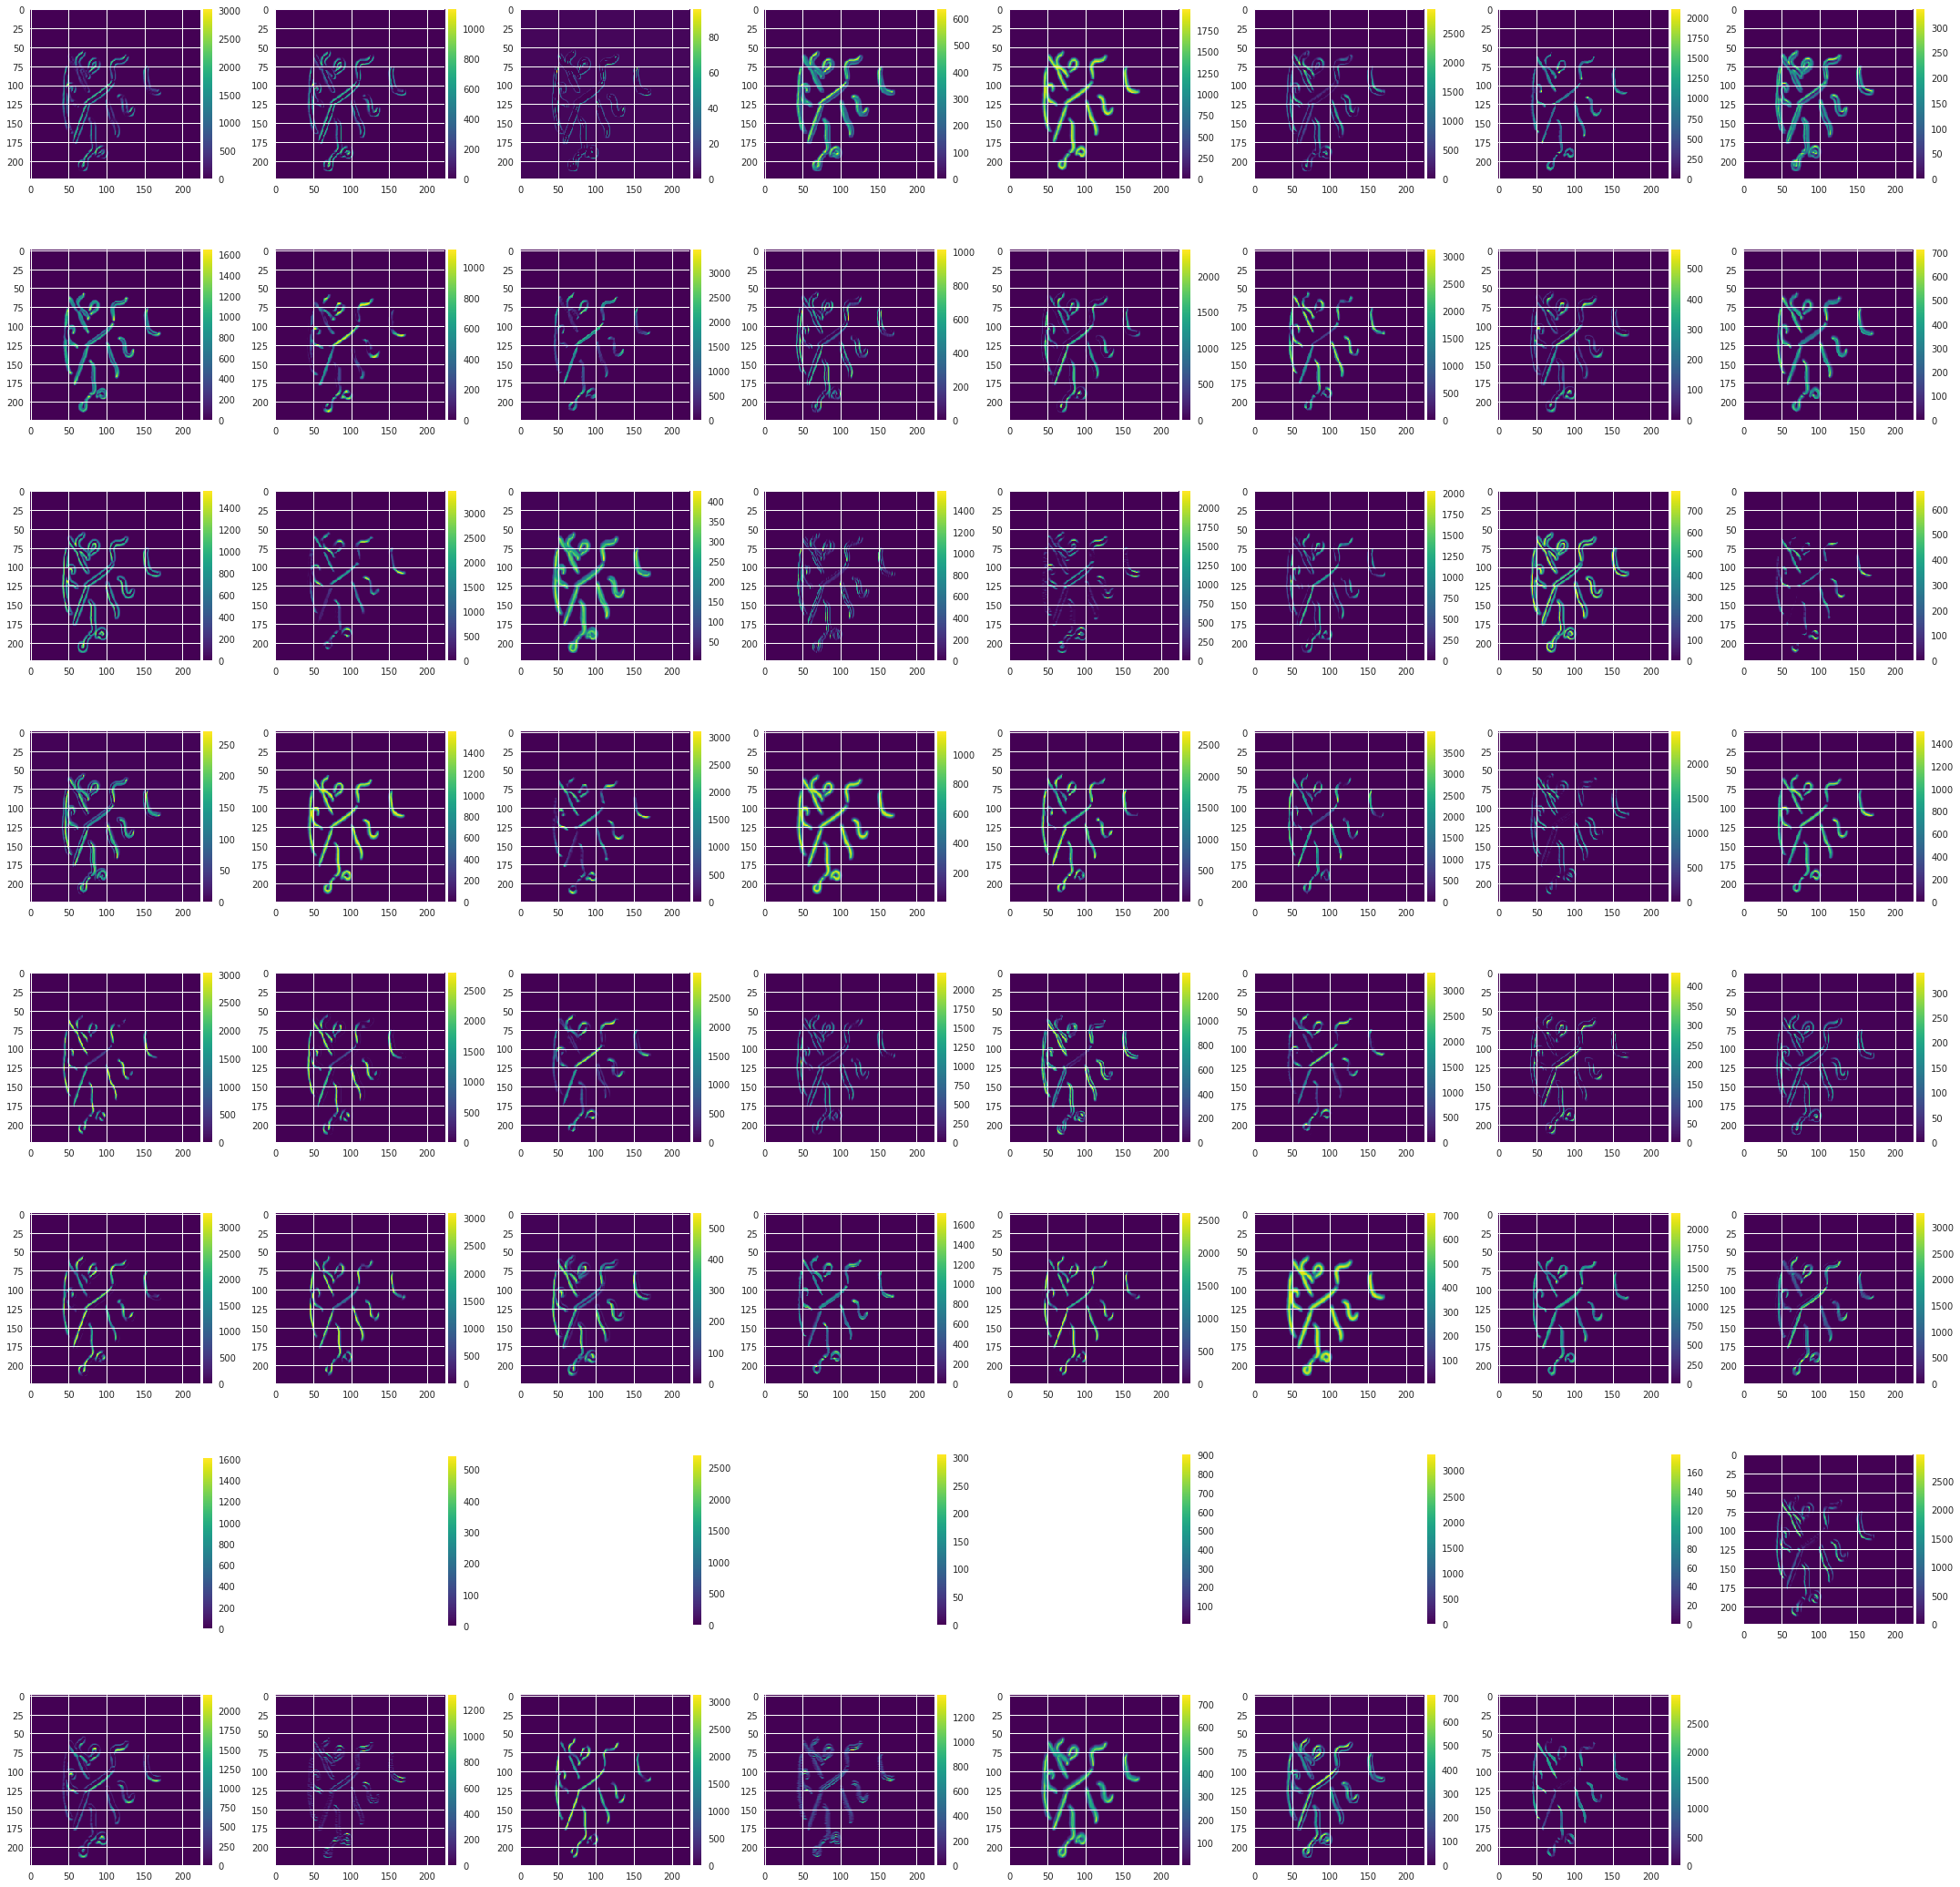

In [384]:
n_channels = intermediate_output.shape[3]

plt.figure(figsize = (30,30))

for channel in range(1, n_channels, 1):
    plt.subplot(np.sqrt(n_channels), np.sqrt(n_channels), channel)
    io.imshow( intermediate_output[0,:,:, channel-1] );

# Conclusion

    In the end, we are able to obtain a perfect classification on the validation set.
    Even though it's small (and the available labelled data is scarce), we are quite sure that the classifiers
    generalize well thanks to the efficient shape detection in VGG16.